# Example notebook for Bayesian transporter protein research

### August George, Zuckerman Lab, 2023

## 1. Import packages and configure sampler
- Use a configuration file (e.g. `./example/antiporter_1_1_12D_cycle1_config.yaml`) to configure the sampler run. 
- Make sure all the file paths are correct in the configuration file
- For a faster (and less accurate) sampling run, reduce the number of walkers from 1000 to 100 and gamma from 0.75 to 0.99 in the configuration file

In [1]:
from bayesian_transporter import analysis_functions as af
from bayesian_transporter import run_pocomc as rpmc 
from bayesian_transporter import utility_functions as uf
import numpy as np
import matplotlib.pyplot as plt
import yaml
import math

config_file = './example/antiporter_1_1_12D_cycle1_config.yaml'

## 2. Run PocoMC sampler

- Results are saved in a new folder, which is used for analysis later. 
- Some useful plots are generated (i.e., observed dataset and nominal model predictions, parameter 'corner' plot, observed dataset vs predicted dataset)

In [ ]:
rpmc.run_sampler(config_file)

## 3. Analyze results
- load sampling data and configuration






In [3]:
# load sampling data for analysis
pocomc_run_folder = './example/example_pocomc_run_folder'  # change as needed
log_like_samples_file = f'{pocomc_run_folder}/log_likelihood.csv'
log_post_samples_file = f'{pocomc_run_folder}/samples.csv'
log_like_samples = np.loadtxt(log_like_samples_file, delimiter=',')
log_post_samples = np.loadtxt(log_post_samples_file, delimiter=',')

# get observed data, parameter names, ranges, and nominal values from config file
with open(config_file, 'r') as f:
    yaml_data = yaml.safe_load(f)
    observed_data = np.loadtxt(str(yaml_data['data_file']), delimiter=',')
    params = yaml_data['bayesian_inference']['parameters']          
    parameter_names = [str(param['name']) for param in params]
    parameter_ranges = [tuple(param['bounds']) for param in params]
    parameter_nominals = [float(param['nominal']) for param in params]


- Plot likelihood distributions
- Estimate Gaussian mixture model (GMM) from samples using minimum Akaike Information Criterion (AIC) 
and Bayesian Information Criterion (BIC)
- Estimate the Kullback–Leibler divergence between GMM (posterior) and uniform (prior) distributions
- Plot parameter distributions w/ GMM overlay
- Plot predicted traces vs observed data using random samples

AIC min: k=29, AIC=-109721.77845100794
BIC min: k=9, AIC=-98542.56876091791
KL divergence of example_run = 45.040366198363806


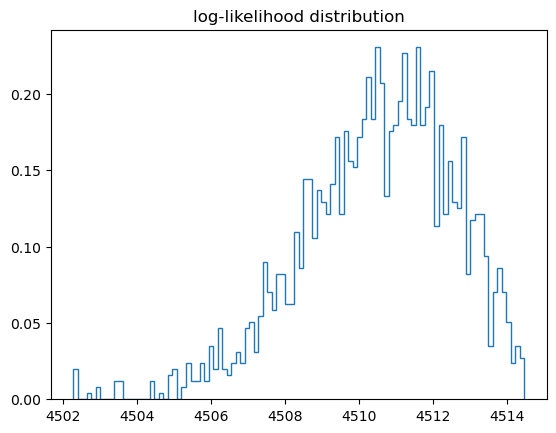

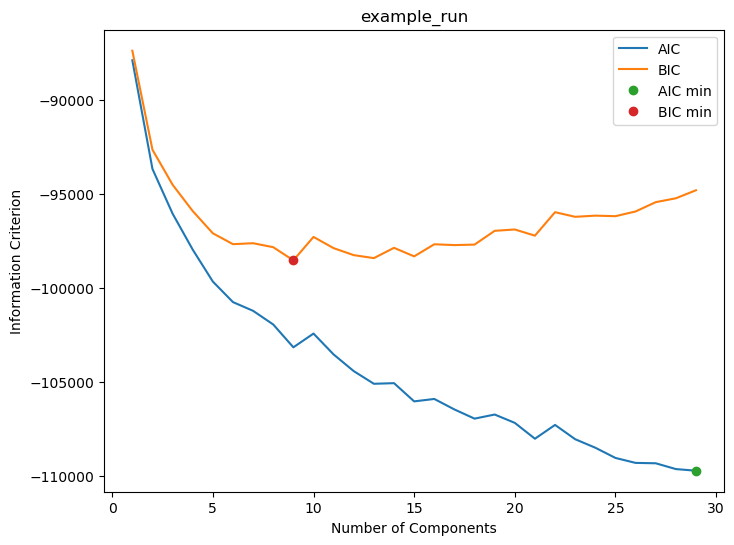

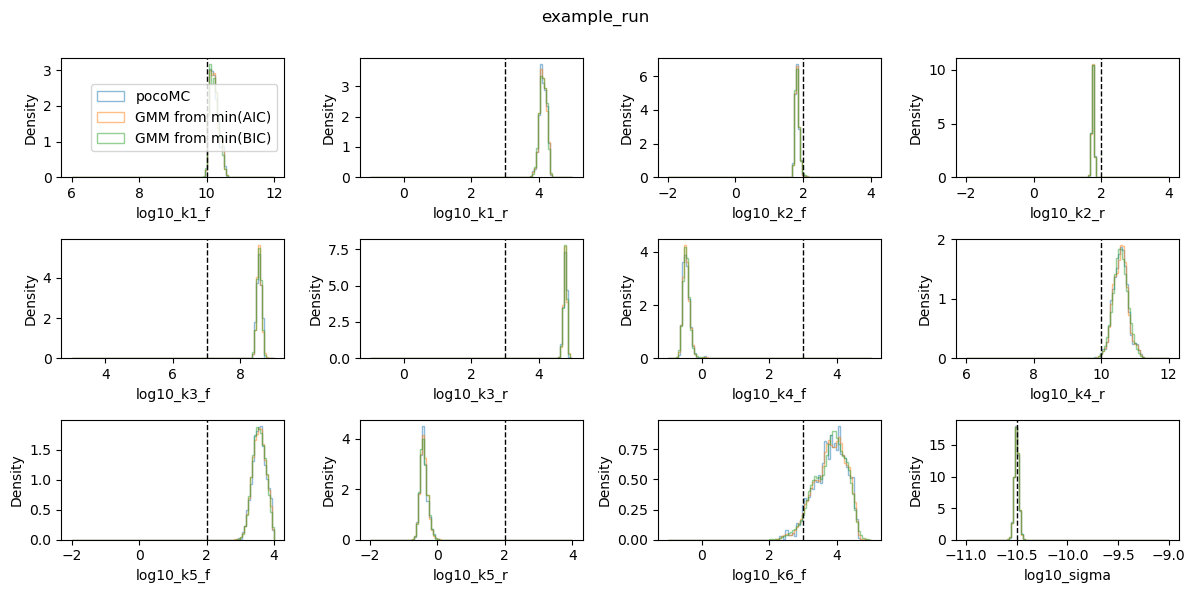

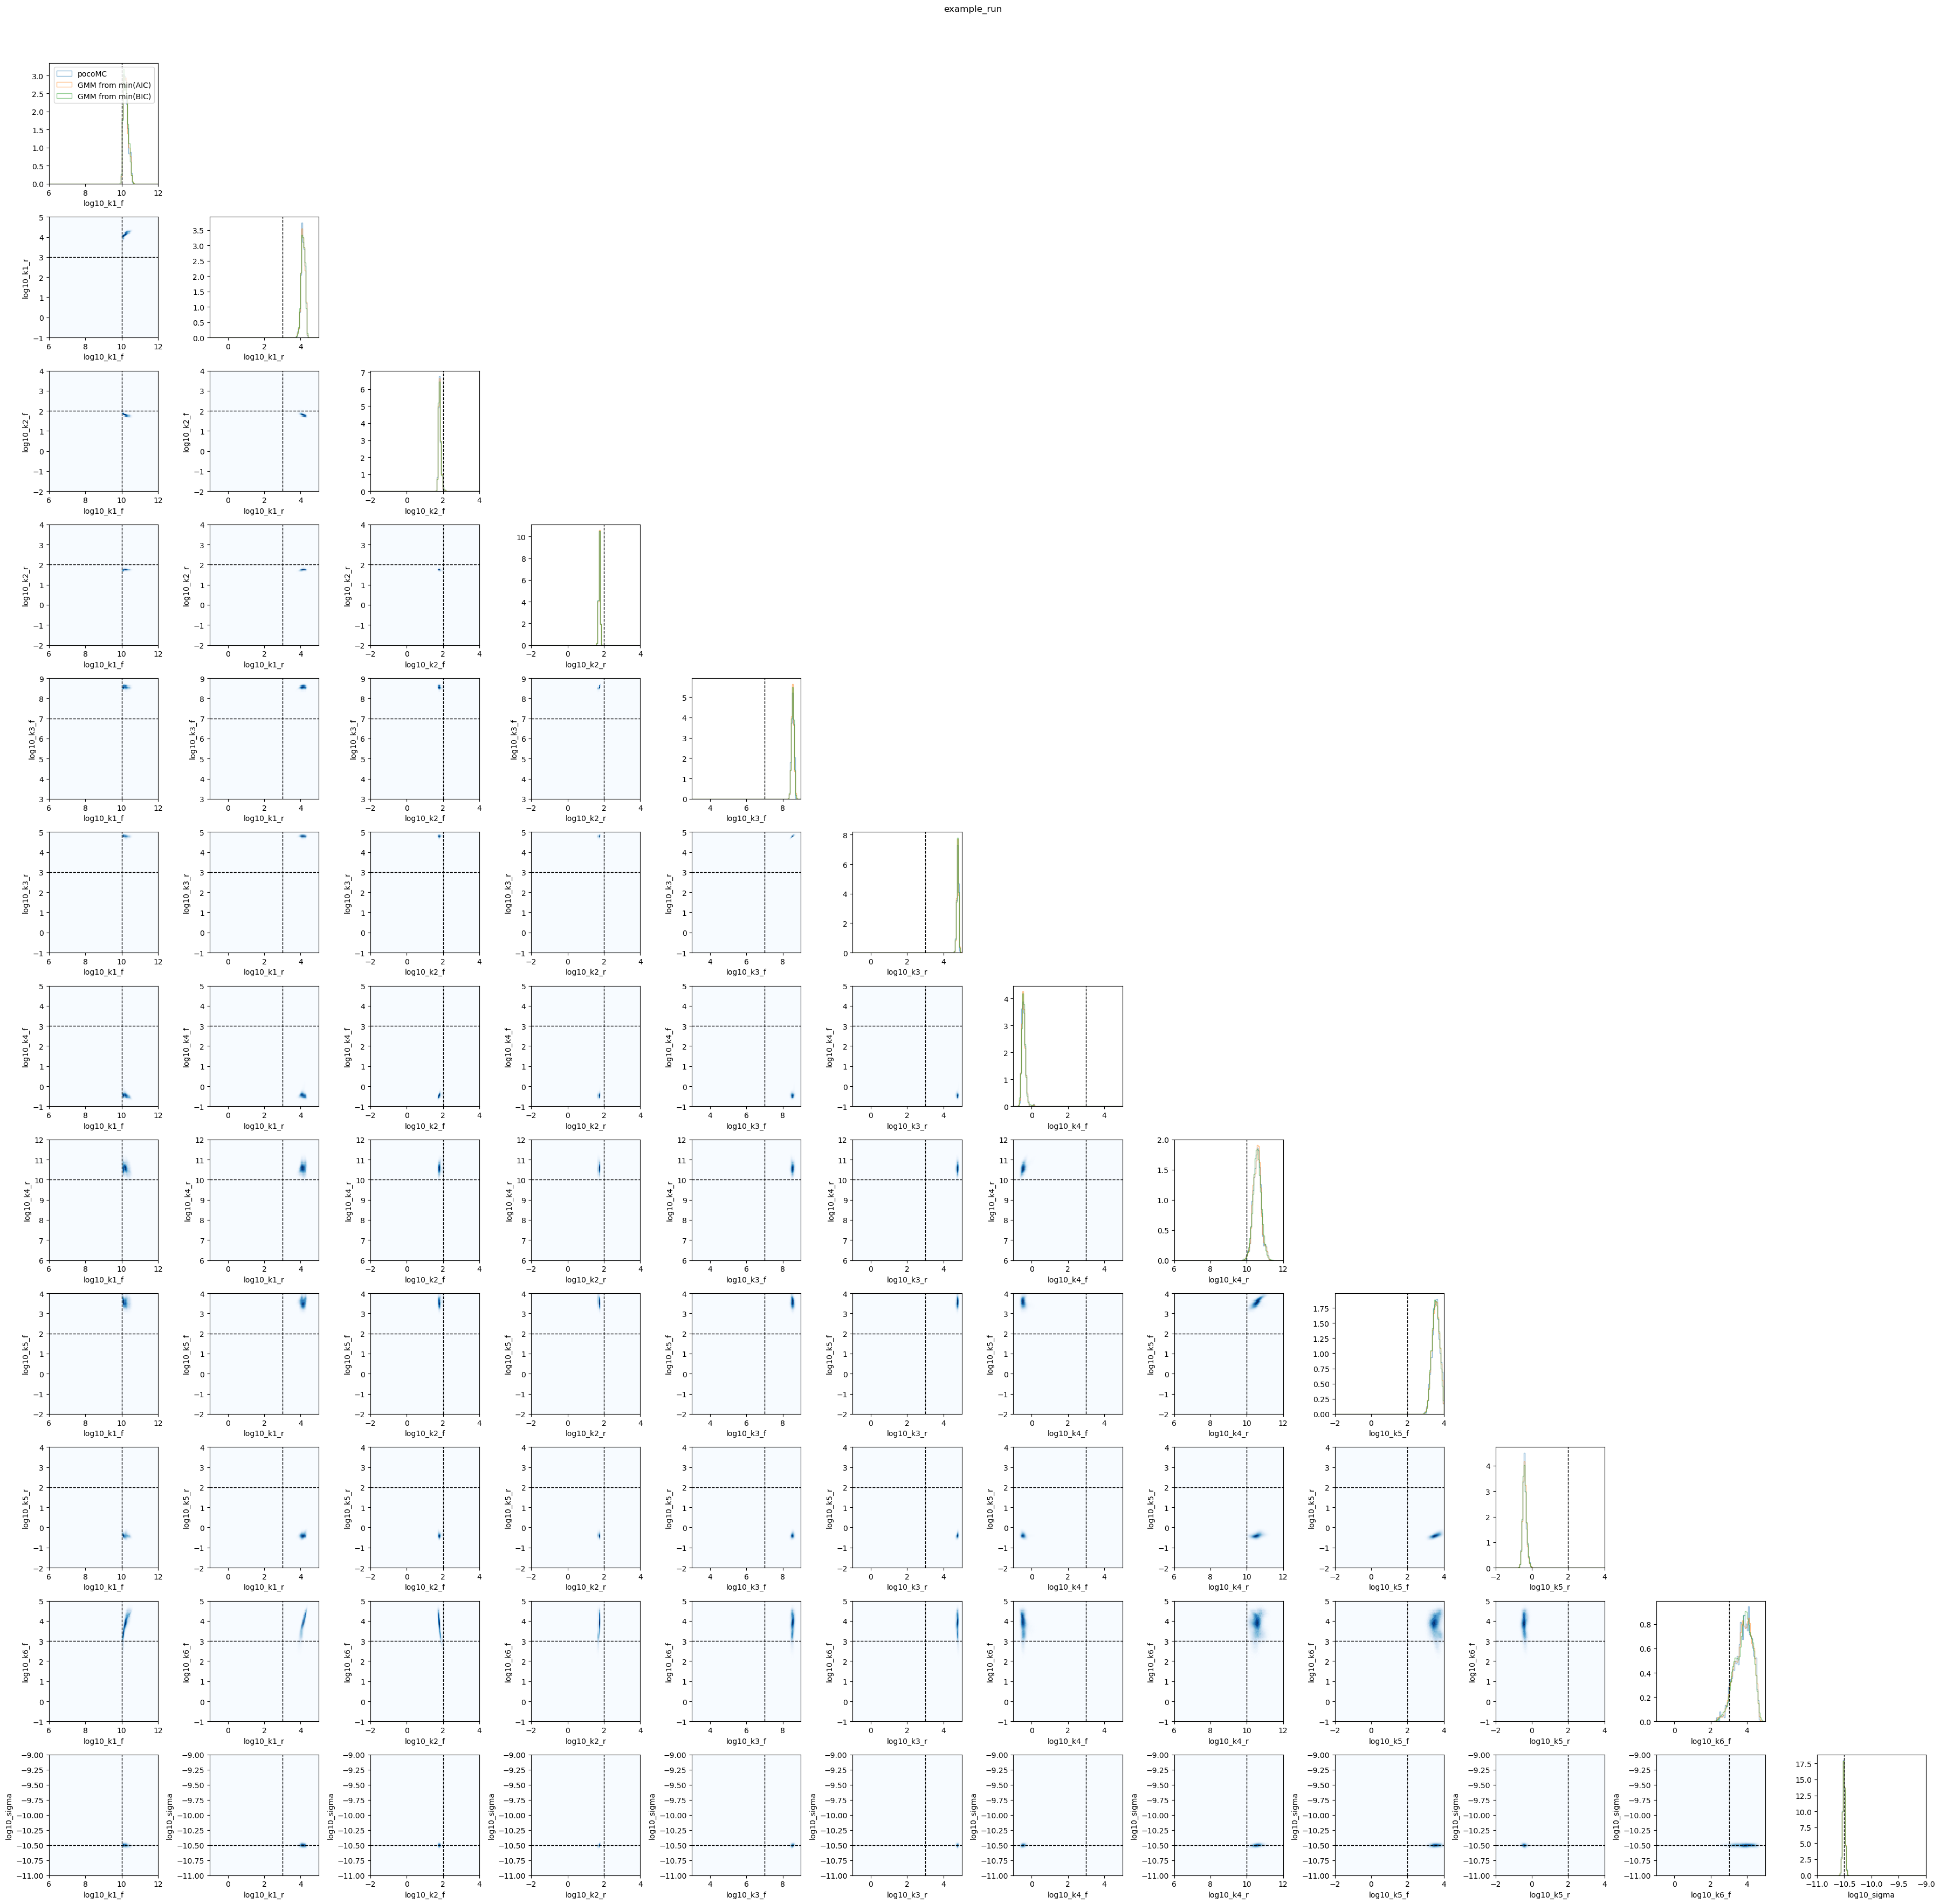

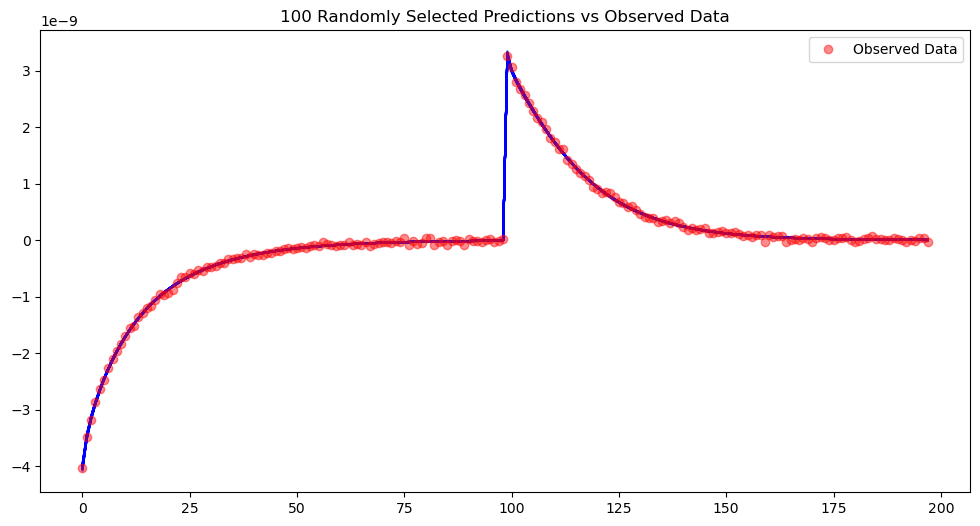

In [4]:
# plot log-likelihood
plt.hist(log_like_samples,bins=100,density=True, histtype='step');
plt.title('log-likelihood distribution')

# estimate a GMM of the posterior and generate samples
gmm_aic, gmm_bic = af.estimate_multivariate_density_w_GMM(log_post_samples,'example_run', plot=True, verbose=True)
samples_gmm_aic,_ = gmm_aic.sample(int(1e5))
samples_gmm_bic,_ = gmm_bic.sample(int(1e5))

# plot 1D parameter distributions (w/ GMM overlay)
sample_arrays = [log_post_samples,samples_gmm_aic,samples_gmm_bic]
sample_labels = ['pocoMC', 'GMM from min(AIC)', 'GMM from min(BIC)']
dist_fig_1D = af.plot_1D_distributions(sample_arrays,sample_labels, parameter_names,parameter_ranges,parameter_nominals, title='example_run')

# plot 2D parameter distributions
dist_fig_2D = af.plot_2D_corner(sample_arrays,sample_labels, parameter_names,parameter_ranges,parameter_nominals, title='example_run')

# plot predicted traces for pocoMC samples
pred_fig = af.plot_random_sample_predictions(log_post_samples, uf.get_ssme_pred_data_from_config, observed_data, N=100, gen_func_args={'config_file':config_file}, title=None)

# estimate KL divergence from GMM of posterior and uniform prior (~ information quantity)
KL_divergence = af.kl_divergence_gmm_uniform(gmm_bic,parameter_ranges,'example_run',verbose=True)